In [95]:
import torch
import torch.nn as nn
from torch import tensor
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
from IPython import display
import pylab as pl
from src.data_structures import Instance
from primes import primes
import seaborn as sns
from torch import nn
import torch.optim as optim
import sys
torch.set_default_tensor_type(torch.FloatTensor)


In [96]:
class VectorQuantization(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(VectorQuantization, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1, 1)  # Inicialización de los embeddings

    def forward(self, x):
        # Redimensionar la entrada para que sea 2D (batch_size, seq_len)
        x = x.view(-1, self.embedding_dim)
        
        # Encontrar el índice más cercano en el diccionario de embeddings
        dist = torch.cdist(x.unsqueeze(0), self.embedding.weight.unsqueeze(0))
        indices = torch.argmin(dist, dim=-1)
        quantized = self.embedding(indices)
        
        # Reshape de vuelta a la forma original
        quantized = quantized.view(x.size())

        return quantized, indices


class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        entrada = 1
        salida = 1
        hidden_size = 20
        self.encoder = nn.Sequential(
            nn.Sigmoid(),
            nn.Linear(entrada, hidden_size),
            nn.Linear(hidden_size, embedding_dim),
        )
        self.vq = VectorQuantization(num_embeddings, embedding_dim)
        self.decoder = nn.Sequential(
            #nn.Linear(embedding_dim, hidden_size),
            #nn.Linear(hidden_size, salida)
            #nn.LeakyReLU(),
            nn.Linear(embedding_dim, salida),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        quantized, indices = self.vq(x)
        x_recon = self.decoder(quantized)
        return x_recon, quantized, indices



## Training Data

In [97]:
#Almacenar los valores de los cuadrados
size = 1000
x = torch.arange(1,size+1,1).view((1,-1)).T.float()/size
y = torch.rand(size,1)

## Modelo

In [98]:
# Crear el modelo VQ-VAE
num_embeddings = 100  # Número de códigos en el diccionario
embedding_dim = 1   # Dimensión de los códigos
model = VQVAE(num_embeddings, embedding_dim)

#Funcion de perdida ;-;
criterion = nn.HuberLoss()

#Optimizer :D
optimizer = optim.SGD(model.parameters(), lr=0.1)



# Entrenamiento
num_epochs = 1000
for epoch in range(num_epochs):
    for i, _ in enumerate(x):
        y_recon, quantized, indices = model(x[i])
        loss = criterion(y_recon, y[i])  # Pérdida de reconstrucción
        # Puedes habilitar la pérdida de compromiso aquí si lo deseas
        loss += torch.mean((quantized - y.detach()) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Debes mover esta declaración de impresión dentro del bucle de entrenamiento
    if (epoch + 1) % 10 == 0:  # Imprimir cada 10 épocas o según lo prefieras
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


In [99]:
# Dividir tus datos en lotes (batch_size es el tamaño del lote)
batch_size = 1
x_batches = x.split(batch_size)
y_batches = y.split(batch_size)

# Entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0.0  # Inicializar la pérdida total para la época
    
    for x_batch, y_batch in zip(x_batches, y_batches):
        optimizer.zero_grad()
        y_recon, quantized, indices = model(x_batch)
        loss = criterion(y_recon, y_batch)  # Pérdida de reconstrucción
        # Puedes habilitar la pérdida de compromiso aquí si lo deseas
        loss += torch.mean((quantized - y_batch.detach()) ** 2)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Debes mover esta declaración de impresión dentro del bucle de entrenamiento
    average_loss = total_loss / len(x_batches)
    sys.stdout.write(f'\rEpoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')
    sys.stdout.flush()

        # Aquí puedes realizar otras acciones, como graficar los resultados si lo deseas
        #sys.stdout.write(f'{quantized}')


Epoch [10/10], Average Loss: 0.3421

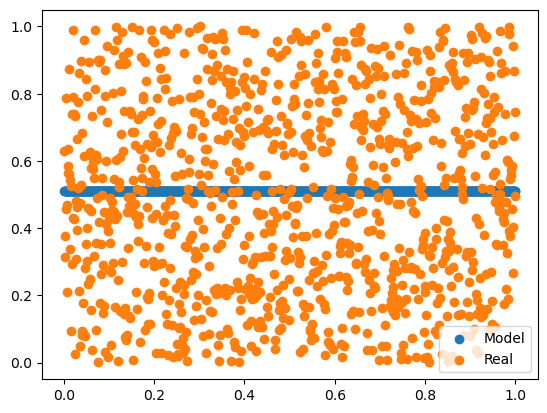

In [100]:
x_recon, quantized, indices = model(x)
plt.scatter(x,x_recon.detach().numpy(),label="Model")
plt.scatter(x,y,label="Real")
plt.legend()
plt.savefig('things.png')
